In [148]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [149]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
output_base_folder = Path("/home/ivan/temp/temp-benchmarking/")


## End to End benchmark
---
Storage performance test on S3 and Scratch with changing the size of the batch, number of workers, number of fetchers, and memory pinning.

**Experiment parameters**

| param | range |
| --- | --- |
| batch size | 16, 32, 64, 128 | 
| num fetch workers |  2, 4, 8, 16, 32, 64 | 
| num workers | 0, 2, 4, 8 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |
| pin memory | True, False | 

---

**Parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch size | asyncio | --- |
| | threaded | --- |
| num fetch workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initiall placed into the task (worker) queue. |
| | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |
| num workers | asyncio | Number of workers that download batches in paralell (while batch items are usually fetched sequentially, here, they are fetched asynchronously) |
| | threaded | The same as for asyncio implementation, however, batch items are fetched with parallel threads and yealded. Once a batch is collected, it is yealded(1). |
| pin memory (2) | asyncio | Host (CPU) data allocations are pageable by default. The GPU cannot access data directly from pageable host memory, so when a data transfer from pageable host memory to device memory is invoked, the CUDA driver must first allocate a temporary page-locked, or “pinned”, host array, copy the host data to the pinned array, and then transfer the data from the pinned array to device memory. Pinned memory is used as a staging area for transfers from the device to the host. We can avoid the cost of the transfer between pageable and pinned host arrays by directly allocating our host arrays in pinned memory. |
| | threaded | Same as for asyncio |

(1) batch_pool_size - Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentiall or in parallel). This implementation takes N batches, and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded. Fixed to 10, as previous experiments show it doesn't have much influence. 

(2) https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

In all plots, lower is better!

### S3 Storage

In [4]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool"]

In [5]:
df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="e2e/*benchmark_dataloader_s3*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14303/14303 [05:21<00:00, 44.52it/s]


Let's visualize the timeline of dataloading, a new color for each thread (cycle 8)

In [80]:
df_dataloader_s3_async=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="asyncio"]
print(f"Records {len(df_dataloader_s3_async)}")

Records 770194


In [7]:
display(get_run_stats(df_dataloader_s3_async, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                       
s3      2                 0           10         20211001f135440_benchmark_dataloader_s3_16_0_2_...          238023224.0   
                                                 20211001f150532_benchmark_dataloader_s3_32_0_2_...          241638466.0   
                                                 20211001f162008_benchmark_dataloader_s3_64_0_2_...          247136743.0   
                                                 20211001f173204_benchmark_dataloader_s3_128_0_2...          247136743.0   
                                                 20211001f183647_benchmark_dataloader_s3_16_0_2_...          238023224.0   
...                                                                                                                  ...   
        64                8           10         20211001f183121_benchmark_dataloader_s3_128_8_6...          494273486.0   
                                                 20211001f194240_benchmark_dataloader_s3_16_8_64...          494273486.0   
                                                 20211001f205452_benchmark_dataloader_s3_32_8_64...          494273486.0   
                                                 20211001f220446_benchmark_dataloader_s3_64_8_64...          494273486.0   
                                                 20211001f231408_benchmark_dataloader_s3_128_8_6...          494273486.0   

                                                                                                       time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                                
s3      2                 0           10         20211001f135440_benchmark_dataloader_s3_16_0_2_...  1.633089e+09   
                                                 20211001f150532_benchmark_dataloader_s3_32_0_2_...  1.633094e+09   
                                                 20211001f162008_benchmark_dataloader_s3_64_0_2_...  1.633098e+09   
                                                 20211001f173204_benchmark_dataloader_s3_128_0_2...  1.633102e+09   
                                                 20211001f183647_benchmark_dataloader_s3_16_0_2_...  1.633106e+09   
...                                                                                                           ...   
        64                8           10         20211001f183121_benchmark_dataloader_s3_128_8_6...  1.633106e+09   
                                                 20211001f194240_benchmark_dataloader_s3_16_8_64...  1.633110e+09   
                                                 20211001f205452_benchmark_dataloader_s3_32_8_64...  1.633114e+09   
                                                 20211001f220446_benchmark_dataloader_s3_64_8_64...  1.633119e+09   
                                                 20211001f231408_benchmark_dataloader_s3_128_8_6...  1.633123e+09   

                                                                                                         time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                                
s3      2                 0           10         20211001f135440_benchmark_dataloader_s3_16_0_2_...  1.633089e+09   
                                                 20211001f150532_benchmark_dataloader_s3_32_0_2_...  1.633094e+09   
                                                 20211001f162008_benchmark_dataloader_s3_64_0_2_...  1.633098e+09   
                                                 20211001f173204_benchmark_dataloader_s3_128_0_2...  1.633102e+09   
                                                 20211001f183647_benchmark_dataloader_s3_16_0_2_...  1.633106e+09   
...                                                                                                           ...   
        64                8   

### Filter

In [8]:
np.unique(df_dataloader_s3_full["num_workers"].to_numpy())

array([0, 2, 4, 8])

In [83]:
import seaborn as sns

def filter_data(df):
    data = pd.DataFrame()
    for num_workers in np.unique(df["num_workers"].to_numpy()):
        for num_fetch_workers in np.unique(df["num_fetch_workers"].to_numpy()):
            for batch_size in np.unique(df["batch_size"].to_numpy()):
                for pin_memory in np.unique(df["pin_memory"].to_numpy()):
                    df_temp=df[(df["num_workers"]==num_workers) &
                                                 (df["num_fetch_workers"]==num_fetch_workers) &
                                                 (df["batch_size"]==batch_size) &
                                                 (df["pin_memory"]==pin_memory)]
                    df_step_time = df_temp[df_temp["trace_name"]=="(6)-training_step"]
                    step_time_list_process_time = df_step_time["process_time"].to_numpy()
                    step_time_list_elapsed = df_step_time["elapsed"].to_numpy()

                    mean_step_time = np.mean(step_time_list_process_time)
                    median_step_time = np.median(step_time_list_process_time)
                    min_step_time = np.min(step_time_list_process_time)
                    max_step_time = np.max(step_time_list_process_time)
                    data = data.append(
                                        {"mean": mean_step_time, 
                                        "median": median_step_time,
                                        "pin_memory": pin_memory, 
                                        "num_workers": num_workers, 
                                        "num_fetch_workers": num_fetch_workers, 
                                        "batch_size": batch_size, 
                                        "config": f"{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}, ignore_index=True)
    return data
data_async = filter_data(df_dataloader_s3_full)

In [84]:
data_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
160,0.005081,0.003991,0.0,8.0,8.0,16.0,"8, 8, 16, 0"
152,0.005176,0.004712,0.0,8.0,4.0,16.0,"8, 4, 16, 0"
104,0.005210,0.004492,0.0,4.0,4.0,16.0,"4, 4, 16, 0"
144,0.005270,0.004101,0.0,8.0,2.0,16.0,"8, 2, 16, 0"
10,0.005301,0.004739,0.0,0.0,4.0,32.0,"0, 4, 32, 0"
...,...,...,...,...,...,...,...
189,0.008896,0.008374,1.0,8.0,64.0,64.0,"8, 64, 64, 1"
85,0.008899,0.008813,1.0,2.0,32.0,64.0,"2, 32, 64, 1"
183,0.008978,0.007693,1.0,8.0,32.0,128.0,"8, 32, 128, 1"
93,0.010305,0.009789,1.0,2.0,64.0,64.0,"2, 64, 64, 1"


Text(0.5, 1.0, 'Average step time with(blue) and without(red) memory pinning')

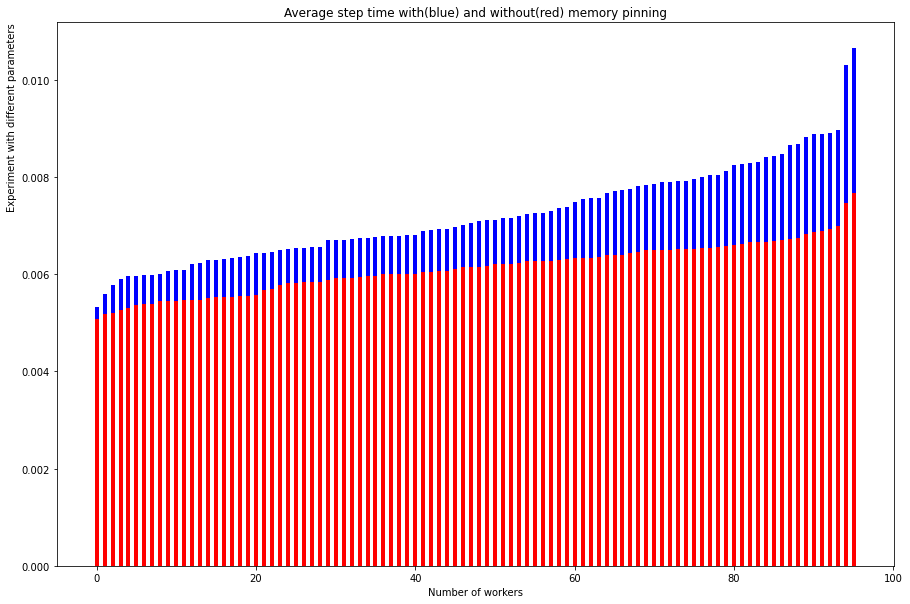

In [157]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_async[data_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_async[data_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Number of workers", loc="center")
ax.set_ylabel("Experiment with different parameters", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning", loc='center')


Considering end-to-end training, and only training step time average, memory_pinning set to False is better.
The best performing configuration is: 

**8 num_workers, 8 num_fetch_workers, 16 batch_size, 0 pin_memory**

In [159]:
from matplotlib.patches import Patch

num_workers_unique = np.unique(df_dataloader_s3_full["num_workers"].to_numpy())
batch_size_unique = np.unique(df_dataloader_s3_full["batch_size"].to_numpy())
num_fetch_workers_unique = np.unique(df_dataloader_s3_full["num_fetch_workers"].to_numpy())


In [92]:
def plot_data(dataframe, fixed_param, fixed_value, changing_param, changing_values):
    fig, ax = plt.subplots(figsize=(15, 10))
    colors = sns.color_palette(None, len(changing_values))
    param_colors = dict(zip(changing_values, colors))
    patches = [Patch(color=v, label=k) for k, v in param_colors.items()]

    for pin_memory in [0, 1]:
        for i, param in enumerate(changing_values):
            plot_data = []
            for num_workers in num_workers_unique:
                data = dataframe[(dataframe["num_workers"]==num_workers) & 
                                  (dataframe["pin_memory"]==pin_memory) & 
                                  (dataframe[changing_param]==param) & 
                                  (dataframe[fixed_param]==fixed_value)].sort_values(["mean"], ascending=True)
                plot_data.append(data["mean"].to_list()[0])
            ax.plot(num_workers_unique, plot_data, color=colors[i], linestyle="--" if pin_memory == 1 else "-")

    ax.legend(title=changing_param, 
              handles=patches, 
              loc='upper left', borderaxespad=0, fontsize=10, frameon=False)
    ax.set_xlabel("Number of workers", loc="center")
    ax.set_ylabel("Average step time", loc="top")
    ax.set_title(f"Average step time vs {changing_param} vs num workers (pin_memory = True -> dashed)", loc='center')

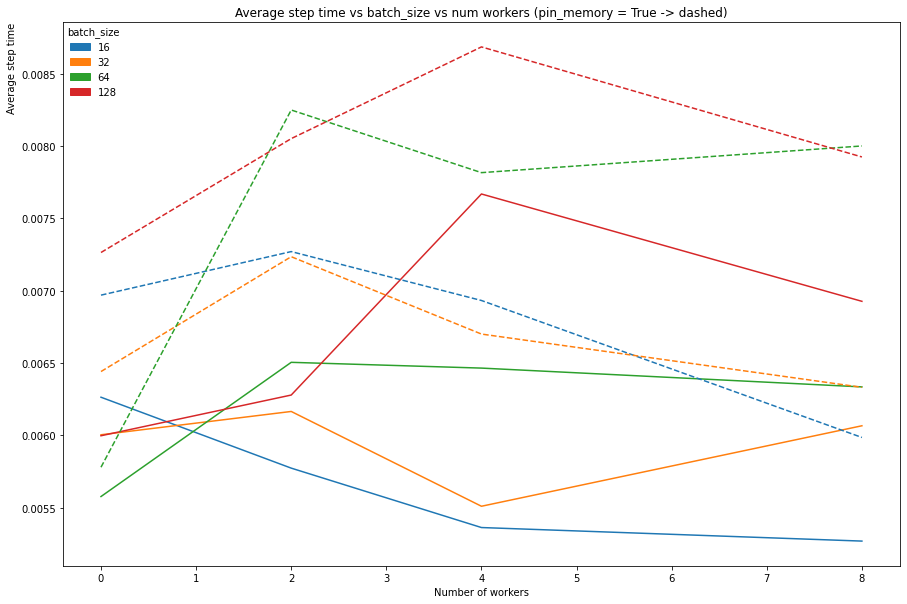

In [93]:
plot_data(data_async, "num_fetch_workers", 2, "batch_size", batch_size_unique)

Smaller batches with more workers perform better.

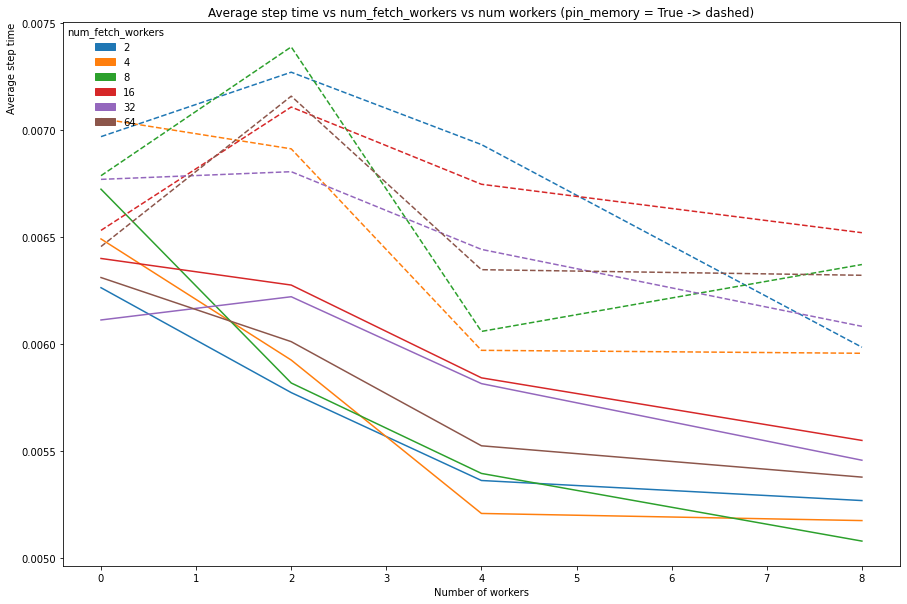

In [94]:
plot_data(data_async, "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

Increasing number of fetch workers, also works better when the number of workers is increased. 
Best performance seem to be when number of workers matches number of fetch workers. 

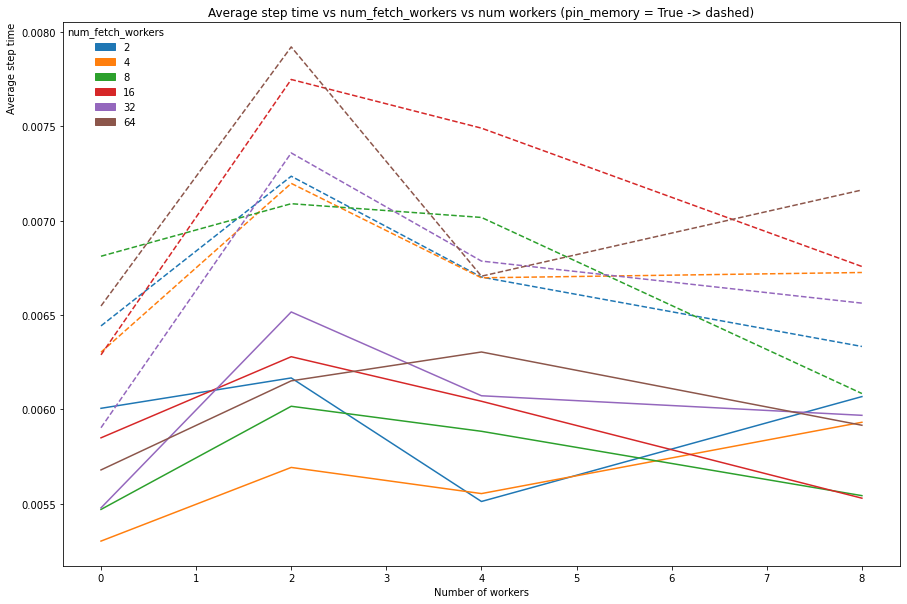

In [64]:
plot_data(data_async, "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

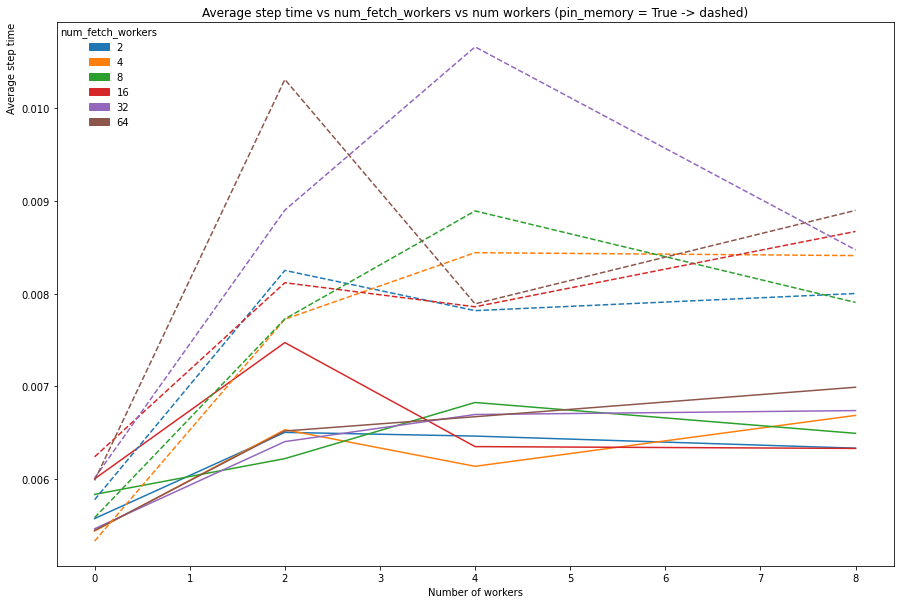

In [65]:
plot_data(data_async, "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

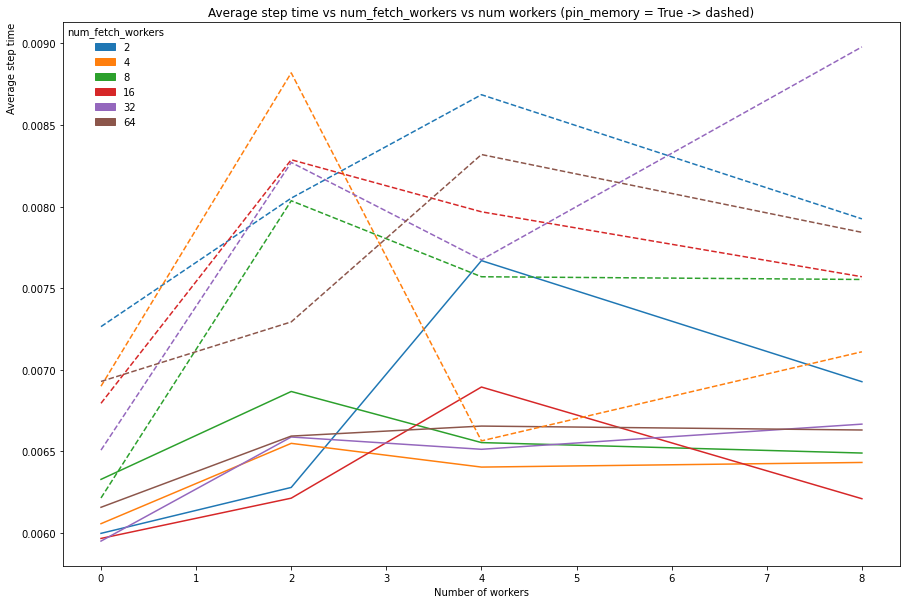

In [68]:
plot_data(data_async, "batch_size", 128, "num_fetch_workers", num_fetch_workers_unique)

The previous example shows that with larger batches, 32 fetch workers with 0 workers seems to be performing the best. 

### S3 Storage

In [75]:
df_dataloader_scratch_full = extract_pandas(output_base_folder, folder_filter="e2e/*benchmark_dataloader_scratch*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14304/14304 [05:01<00:00, 47.48it/s]


In [79]:
df_dataloader_scratch_async=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="asyncio"]
print(f"Records {len(df_dataloader_scratch_async)}")

Records 768250


In [81]:
display(get_run_stats(df_dataloader_scratch_async, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                       
scratch 2                 0           10         20211001f231927_benchmark_dataloader_scratch_16...          302605942.0   
                                                 20211001f233401_benchmark_dataloader_scratch_32...          305547761.0   
                                                 20211001f234847_benchmark_dataloader_scratch_64...          316401394.0   
                                                 20211002f000057_benchmark_dataloader_scratch_12...          316401394.0   
                                                 20211002f001457_benchmark_dataloader_scratch_16...          302605942.0   
...                                                                                                                  ...   
        64                8           10         20211002f001417_benchmark_dataloader_scratch_12...          632802788.0   
                                                 20211002f003247_benchmark_dataloader_scratch_16...          606338122.0   
                                                 20211002f004816_benchmark_dataloader_scratch_32...          632802788.0   
                                                 20211002f010206_benchmark_dataloader_scratch_64...          632802788.0   
                                                 20211002f011539_benchmark_dataloader_scratch_12...          632802788.0   

                                                                                                       time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 2                 0           10         20211001f231927_benchmark_dataloader_scratch_16...  1.633123e+09   
                                                 20211001f233401_benchmark_dataloader_scratch_32...  1.633124e+09   
                                                 20211001f234847_benchmark_dataloader_scratch_64...  1.633125e+09   
                                                 20211002f000057_benchmark_dataloader_scratch_12...  1.633126e+09   
                                                 20211002f001457_benchmark_dataloader_scratch_16...  1.633126e+09   
...                                                                                                           ...   
        64                8           10         20211002f001417_benchmark_dataloader_scratch_12...  1.633126e+09   
                                                 20211002f003247_benchmark_dataloader_scratch_16...  1.633128e+09   
                                                 20211002f004816_benchmark_dataloader_scratch_32...  1.633128e+09   
                                                 20211002f010206_benchmark_dataloader_scratch_64...  1.633129e+09   
                                                 20211002f011539_benchmark_dataloader_scratch_12...  1.633130e+09   

                                                                                                         time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 2                 0           10         20211001f231927_benchmark_dataloader_scratch_16...  1.633123e+09   
                                                 20211001f233401_benchmark_dataloader_scratch_32...  1.633124e+09   
                                                 20211001f234847_benchmark_dataloader_scratch_64...  1.633125e+09   
                                                 20211002f000057_benchmark_dataloader_scratch_12...  1.633126e+09   
                                                 20211002f001457_benchmark_dataloader_scratch_16...  1.633127e+09   
...                                                                                                           ...   
        64                8   

In [82]:
np.unique(df_dataloader_scratch_async["num_workers"].to_numpy())

array([0, 2, 4, 8])

In [99]:
data_scratch_async = filter_data(df_dataloader_scratch_full)

In [87]:
data_scratch_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
12,0.004804,0.004244,0.0,0.0,4.0,64.0,"0, 4, 64, 0"
4,0.005036,0.004217,0.0,0.0,2.0,64.0,"0, 2, 64, 0"
128,0.005263,0.004475,0.0,4.0,32.0,16.0,"4, 32, 16, 0"
144,0.005314,0.004360,0.0,8.0,2.0,16.0,"8, 2, 16, 0"
18,0.005344,0.004719,0.0,0.0,8.0,32.0,"0, 8, 32, 0"
...,...,...,...,...,...,...,...
164,0.009579,0.010210,0.0,8.0,8.0,64.0,"8, 8, 64, 0"
157,0.009760,0.009762,1.0,8.0,4.0,64.0,"8, 4, 64, 1"
165,0.009943,0.009850,1.0,8.0,8.0,64.0,"8, 8, 64, 1"
125,0.010058,0.010339,1.0,4.0,16.0,64.0,"4, 16, 64, 1"


Text(0.5, 1.0, 'Average step time with(blue) and without(red) memory pinning')

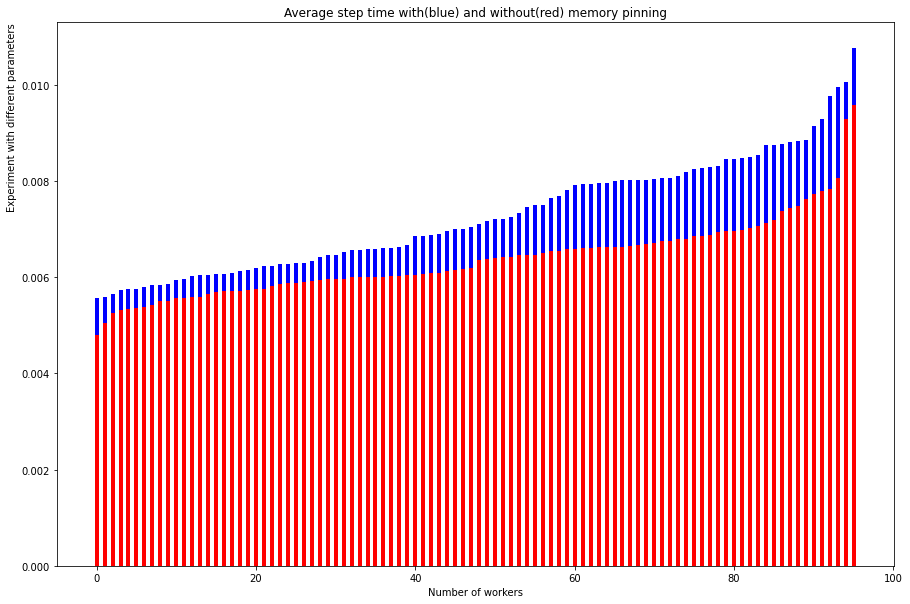

In [158]:
# fig, ax = plt.subplots(figsize=(15, 10))
# param_unique = np.unique(data_scratch_async["pin_memory"].to_numpy())
# colors = sns.color_palette(None, len(param_unique))
# for i, param in enumerate(param_unique[::-1]):
#     data = data_scratch_async[data_scratch_async["pin_memory"]==param].sort_values(["mean"], ascending=True)
#     ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color=colors[i])
    
fig, ax = plt.subplots(figsize=(15, 10))
data = data_scratch_async[data_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_async[data_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Number of workers", loc="center")
ax.set_ylabel("Experiment with different parameters", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning", loc='center')

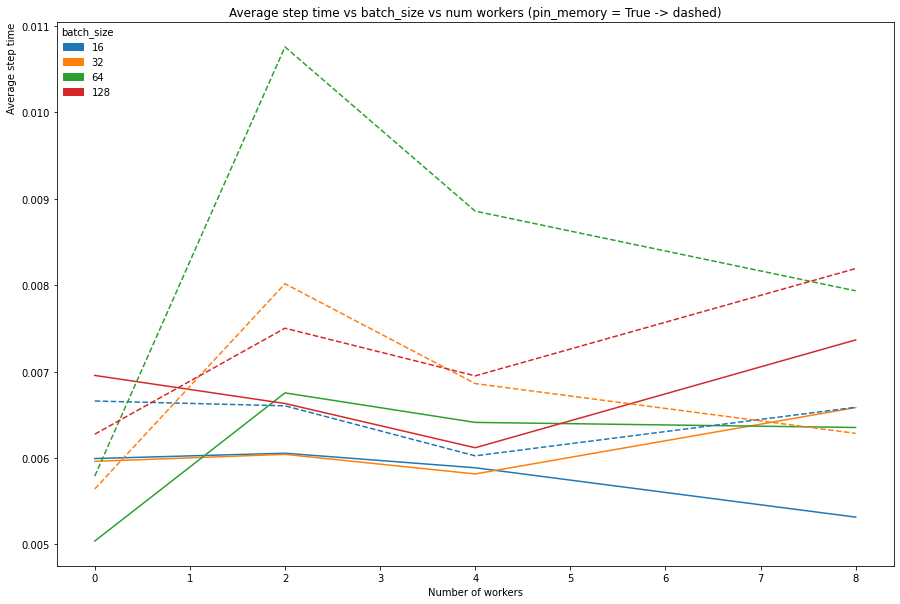

In [100]:
plot_data(data_scratch_async, "num_fetch_workers", 2, "batch_size", batch_size_unique)

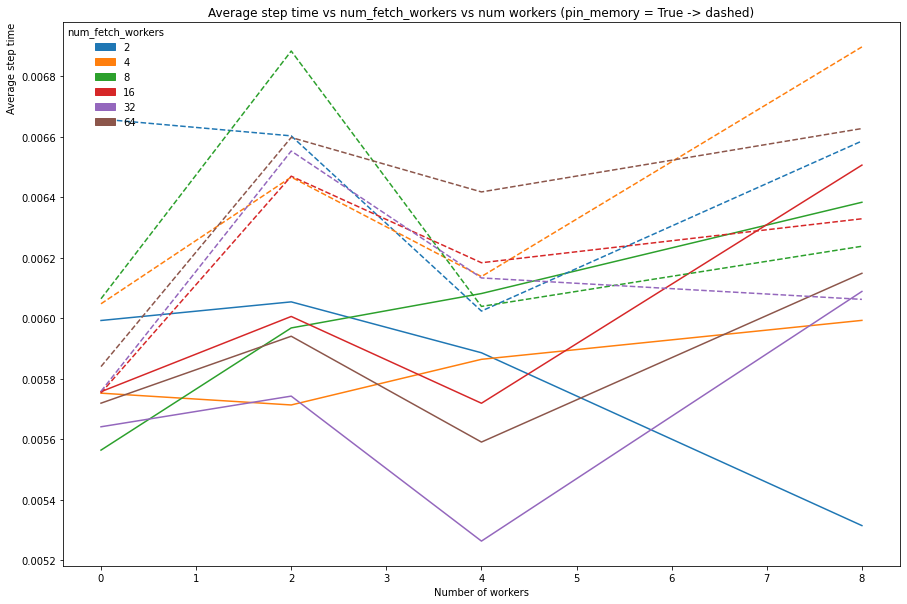

In [101]:
plot_data(data_scratch_async, "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

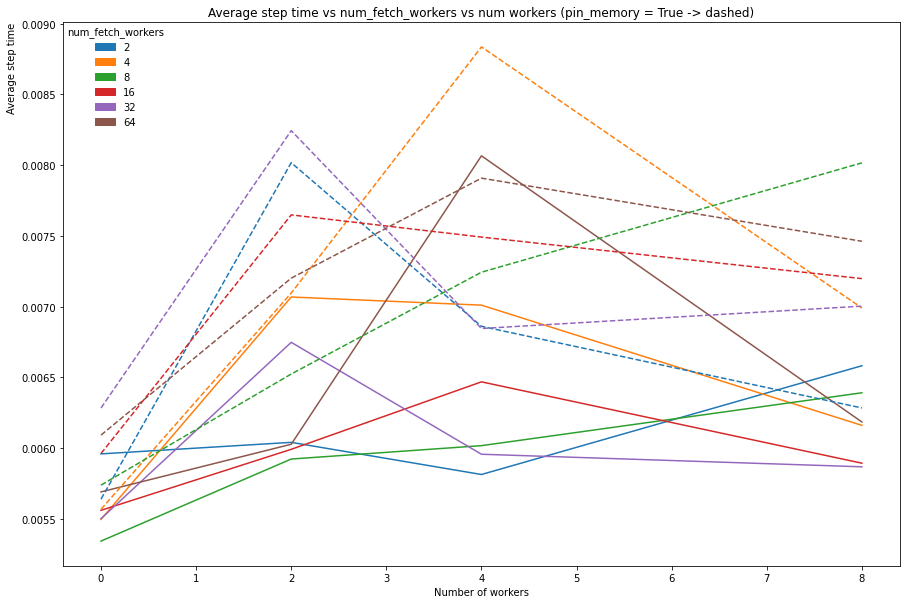

In [102]:
plot_data(data_scratch_async, "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

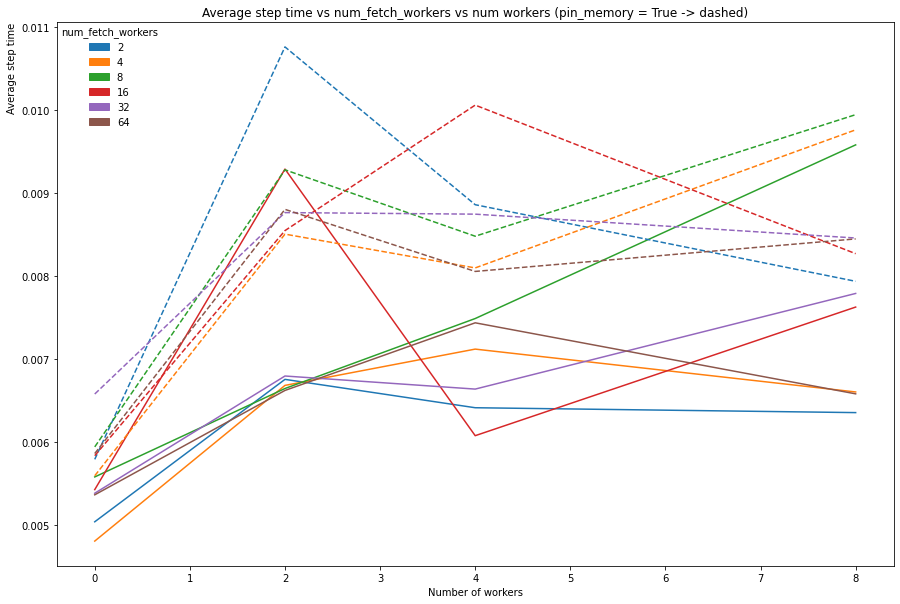

In [103]:
plot_data(data_scratch_async, "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

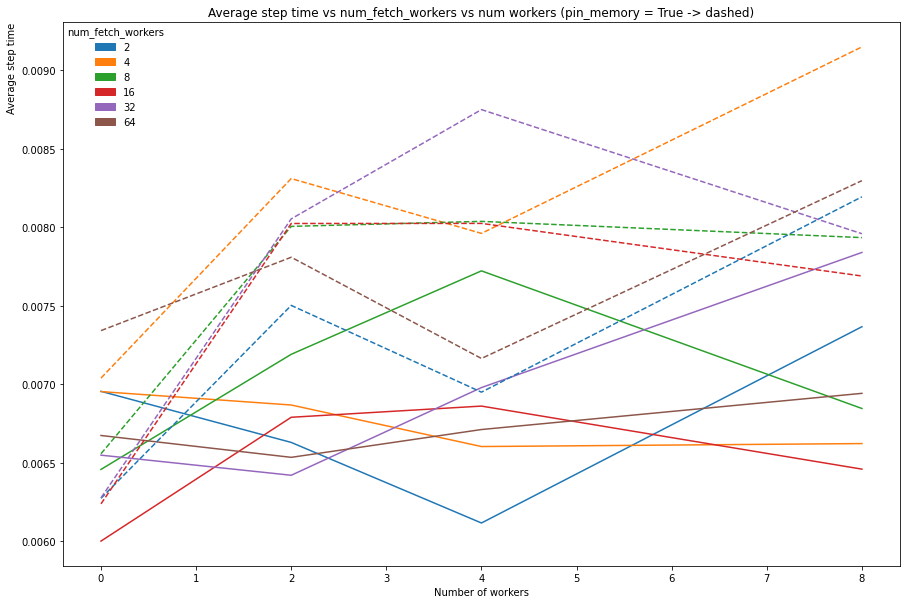

In [104]:
plot_data(data_scratch_async, "batch_size", 128, "num_fetch_workers", num_fetch_workers_unique)

### S3 vs Scratch - mean step time

<BarContainer object of 96 artists>

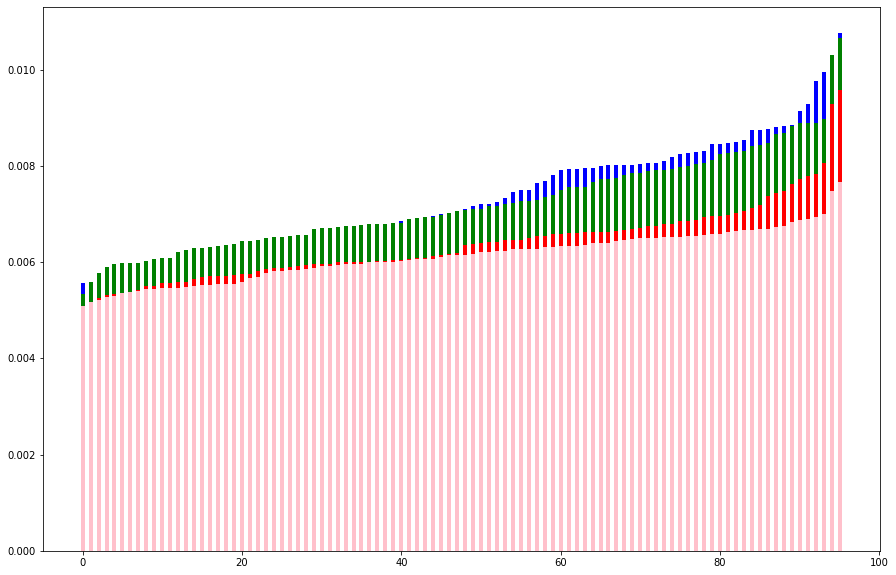

In [163]:
fig, ax = plt.subplots(figsize=(15, 10))

scratch_p = data_scratch_async[data_scratch_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
scratch_up = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
s3_p = data_async[data_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_up = data_async[data_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(scratch_p)), height=scratch_p["mean"], width=0.5, color="blue")
ax.bar(x=range(len(s3_p)), height=s3_p["mean"], width=0.5, color="green")
ax.bar(x=range(len(scratch_up)), height=scratch_up["mean"], width=0.5, color="red")
ax.bar(x=range(len(s3_up)), height=s3_up["mean"], width=0.5, color="pink")

Considering the chart, we can ignore pinning memory, and just explore S3 vs Scratch for cases pin_memory=False:

<BarContainer object of 96 artists>

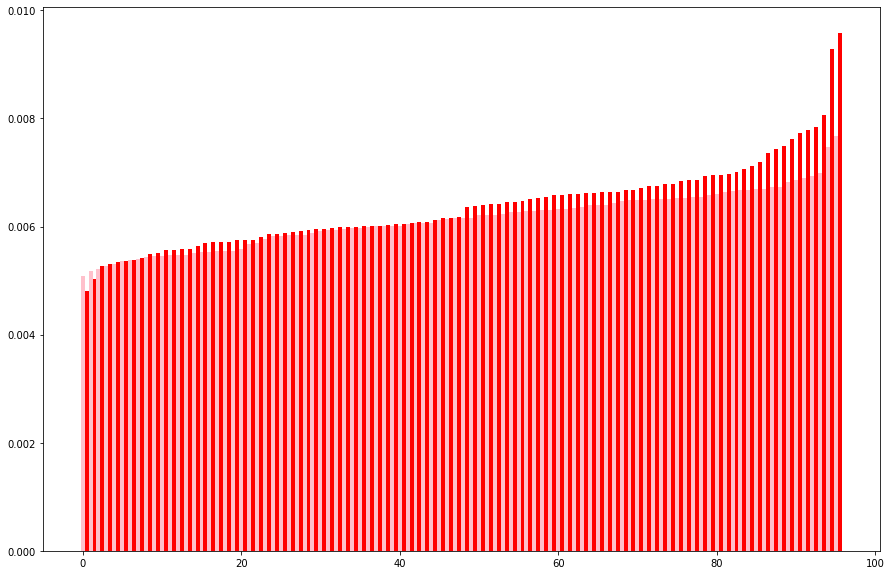

In [169]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=[x+0.5 for x in range(len(scratch_up))], height=scratch_up["mean"], width=0.5, color="red")
ax.bar(x=range(len(s3_up)), height=s3_up["mean"], width=0.5, color="pink")

We find that with some combinations we can get slightly better performance.

In [186]:
# print(s3_up[["mean", "config"]], scratch_up[["mean", "config"]])
df_joined = df_concat = pd.concat([s3_up[["mean", "config"]], scratch_up[["mean", "config"]]], axis=1)
df_joined['diff'] = df_joined.apply(lambda row: float(row[2] - row[0]) , axis = 1)
df_joined = df_joined.set_axis(["s3_mean", "s3_config", "scratch_mean", "scratch_config", "diff"], axis=1, inplace=False)
print(df_joined.sort_values(["diff"], ascending=True))
# {num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}

      s3_mean     s3_config  scratch_mean scratch_config      diff
102  0.007669  4, 2, 128, 0      0.006117   4, 2, 128, 0 -0.001552
16   0.006724   0, 8, 16, 0      0.005563    0, 8, 16, 0 -0.001161
8    0.006492   0, 4, 16, 0      0.005752    0, 4, 16, 0 -0.000740
24   0.006401  0, 16, 16, 0      0.005757   0, 16, 16, 0 -0.000644
12   0.005444   0, 4, 64, 0      0.004804    0, 4, 64, 0 -0.000640
..        ...           ...           ...            ...       ...
58   0.005691   2, 4, 32, 0      0.007068    2, 4, 32, 0  0.001377
106  0.005553   4, 4, 32, 0      0.007010    4, 4, 32, 0  0.001458
138  0.006303  4, 64, 32, 0      0.008065   4, 64, 32, 0  0.001762
76   0.007472  2, 16, 64, 0      0.009287   2, 16, 64, 0  0.001815
164  0.006495   8, 8, 64, 0      0.009579    8, 8, 64, 0  0.003084

[96 rows x 5 columns]
